# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
	set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		# np.logspace(1, 2, 2, dtype=int).tolist(), # 100, for CI tests
		np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    set_serialize_minimal_threshold(None)
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize_full', _d_cpy._serialize_full, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    # info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
    #     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    # )
    # row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load_full', lambda: MazeDataset._load_full(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    set_serialize_minimal_threshold(None)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    set_serialize_minimal_threshold(0)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    set_serialize_minimal_threshold(None)

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/5:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001F8474CADE0>, maze_ctor_kwargs={})
	{'grid_n': 10, 'n_mazes': 10, 'serialize_full': 0.004557900014333427, 'serialize_minimal': 0.004574800026603043, 'serialize_minimal_soln_cat': 0.004195199930109084, 'load_full': 0.022040599957108498, 'load_minimal': 0.0011724999640136957, 'load_minimal_soln_cat': 0.003911999985575676, 'save': 0.06636699999216944, 'read': 0.032292300020344555, 'save_minimal': 0.01920159999281168, 'read_minimal': 0.009827899979427457}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs a

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS


,grid_n,n_mazes,serialize_full,serialize_full:stats,serialize_full:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_soln_cat,serialize_minimal_soln_cat:stats,...,save:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,10,0.004558,{0.004557900014333427: 1},<pstats.Stats object at 0x000001F8486DF450>,0.004575,{0.004574800026603043: 1},<pstats.Stats object at 0x000001F848713990>,0.004195,{0.004195199930109084: 1},...,<pstats.Stats object at 0x000001F8486F8050>,0.032292,{0.032292300020344555: 1},<pstats.Stats object at 0x000001F8487D4DD0>,0.019202,{0.01920159999281168: 1},<pstats.Stats object at 0x000001F8486DF250>,0.009828,{0.009827899979427457: 1},<pstats.Stats object at 0x000001F84606B6D0>
1,10,31,0.002213,{0.002213100087828934: 1},<pstats.Stats object at 0x000001F8488B5850>,0.007545,{0.007545299944467843: 1},<pstats.Stats object at 0x000001F848776690>,0.006867,{0.0068669000174850225: 1},...,<pstats.Stats object at 0x000001F8486DA610>,0.080793,{0.08079269994050264: 1},<pstats.Stats object at 0x000001F8488F9210>,0.020210,{0.02021039999090135: 1},<pstats.Stats object at 0x000001F8487568D0>,0.008399,{0.008398899924941361: 1},<pstats.Stats object at 0x000001F8488D4650>
2,10,100,0.002959,{0.0029588000616058707: 1},<pstats.Stats object at 0x000001F84885A810>,0.002425,{0.0024251999566331506: 1},<pstats.Stats object at 0x000001F84885B990>,0.002192,{0.0021922000451013446: 1},...,<pstats.Stats object at 0x000001F848576B10>,0.025085,{0.025085499975830317: 1},<pstats.Stats object at 0x000001F84892CFD0>,0.020355,{0.020355100044980645: 1},<pstats.Stats object at 0x000001F848706150>,0.009816,{0.009816100005991757: 1},<pstats.Stats object at 0x000001F84864CF10>
3,10,316,0.003335,{0.003334700013510883: 1},<pstats.Stats object at 0x000001F848A78310>,0.002380,{0.002379500074312091: 1},<pstats.Stats object at 0x000001F848A0CD90>,0.004917,{0.004916999954730272: 1},...,<pstats.Stats object at 0x000001F845D34CD0>,0.064179,{0.06417920009698719: 1},<pstats.Stats object at 0x000001F847170A10>,0.028556,{0.028556099976412952: 1},<pstats.Stats object at 0x000001F84883FF10>,0.011896,{0.01189580000936985: 1},<pstats.Stats object at 0x000001F848E38350>
4,10,1000,0.007612,{0.007612199988216162: 1},<pstats.Stats object at 0x000001F848C43450>,0.003638,{0.003638499998487532: 1},<pstats.Stats object at 0x000001F848D49910>,0.005718,{0.005717799998819828: 1},...,<pstats.Stats object at 0x000001F8486E74D0>,0.187815,{0.187815299956128: 1},<pstats.Stats object at 0x000001F848942C10>,0.058486,{0.05848599993623793: 1},<pstats.Stats object at 0x000001F8485CA750>,0.021961,{0.021960699930787086: 1},<pstats.Stats object at 0x000001F848ED8ED0>


In [7]:


def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
    # for prefix in column_measurement_prefixes:
    #     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
    speeds['serialize/speedup'] = speeds['serialize_full'] / speeds['serialize_minimal']
    speeds['load/speedup'] = speeds['load_full'] / speeds['load_minimal']
    speeds['save/speedup'] = speeds['save'] / speeds['save_minimal']
    speeds['read/speedup'] = speeds['read'] / speeds['read_minimal']

    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [8]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_full,load_minimal,load_minimal_soln_cat,save,read,save_minimal,read_minimal,serialize/speedup,load/speedup,save/speedup,read/speedup
0,10,10,0.004558,0.004575,0.004195,0.022041,0.001172,0.003912,0.066367,0.032292,0.019202,0.009828,0.996306,18.797954,3.456327,3.285778
1,10,31,0.002213,0.007545,0.006867,0.088402,0.001447,0.003573,0.110737,0.080793,0.020210,0.008399,0.293308,61.089002,5.479214,9.619438
2,10,100,0.002959,0.002425,0.002192,0.013109,0.003207,0.004899,0.141026,0.025085,0.020355,0.009816,1.220023,4.087400,6.928273,2.555546
3,10,316,0.003335,0.002380,0.004917,0.076616,0.005029,0.007844,0.060791,0.064179,0.028556,0.011896,1.401429,15.234133,2.128813,5.395114
4,10,1000,0.007612,0.003638,0.005718,0.116265,0.013375,0.016918,0.162239,0.187815,0.058486,0.021961,2.092126,8.692863,2.773982,8.552337


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


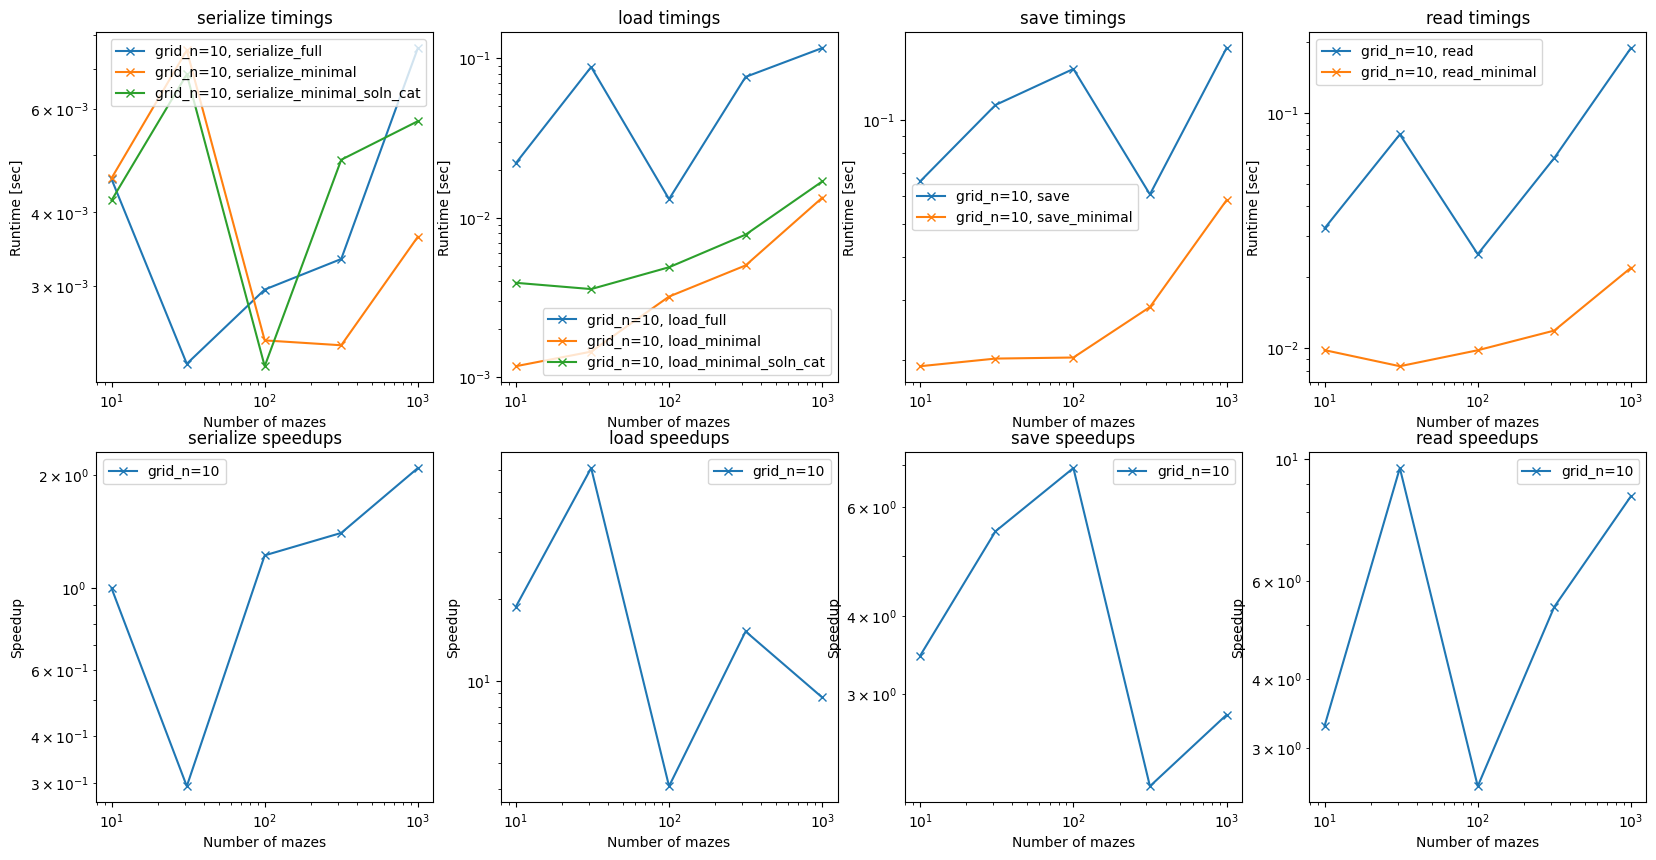

In [9]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}/speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [10]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_soln_cat:profiling']]

,grid_n,n_mazes,serialize_minimal_soln_cat:profiling
0,10,10,<pstats.Stats object at 0x000001F84874BF10>
1,10,31,<pstats.Stats object at 0x000001F84896BE10>
2,10,100,<pstats.Stats object at 0x000001F848509AD0>
3,10,316,<pstats.Stats object at 0x000001F848A78D90>
4,10,1000,<pstats.Stats object at 0x000001F848CEC650>


In [11]:
SPEEDS['serialize_minimal_soln_cat:profiling'][len(SPEEDS)-1].sort_stats('tottime').print_stats()

         7044 function calls (6819 primitive calls) in 0.008 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.008    0.008 maze_dataset.py:407(_serialize_minimal_soln_cat)
      724    0.002    0.000    0.003    0.000 tokenize.py:433(_tokenize)
     1001    0.001    0.000    0.001    0.000 {built-in method numpy.array}
      671    0.001    0.000    0.001    0.000 {method 'match' of 're.Pattern' objects}
        1    0.000    0.000    0.004    0.004 inspect.py:1224(getblock)
      723    0.000    0.000    0.000    0.000 inspect.py:1181(tokeneater)
      723    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.000    0.000 maze_dataset.py:414(<listcomp>)
    195/2    0.000    0.000    0.005    0.002 json_serialize.py:231(json_serialize)
      723    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x00007FFB8BC98F90}
      8/1    